In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import shutil

shutil.rmtree('/content/Gastric_cancer/Gastric_Cancer/Train/STR')
shutil.rmtree('/content/Gastric_cancer/Gastric_Cancer/Test/STR')

In [ ]:
data=pd.read_csv(r"/content/Gastric_cancer/Gastric_Cancer/HMU-GC-Clinical.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Patient                                                  300 non-null    int64  
 1   Sex                                                      300 non-null    object 
 2   Age                                                      300 non-null    int64  
 3   T staging                                                300 non-null    object 
 4   N staging                                                300 non-null    object 
 5   M staging                                                300 non-null    object 
 6   Comprehensive Staging                                    300 non-null    object 
 7   Histological Type                                        300 non-null    object 
 8   Lauren classification(Intestin

In [ ]:
# Install PyTorch and TorchVision libraries for deep learning
!pip install torch torchvision

In [ ]:
# Import PyTorch modules and other necessary libraries for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os, random
import numpy as np
from collections import defaultdict
from imblearn.over_sampling import SMOTE

In [ ]:
# Applying contrastive learning transformations to images
class ContrastiveTransform:
    def __init__(self, size=224):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),  # Randomly crop and resize the image
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
            transforms.RandomRotation(15),  # Randomly rotate the image
            transforms.ColorJitter(0.5,0.5,0.5,0.1),  # Randomly change the brightness, contrast, saturation, and hue
            transforms.RandomGrayscale(p=0.2),  # Randomly convert the image to grayscale
            transforms.ToTensor()  # Convert the image to a PyTorch tensor
        ])

    # Apply the transformations twice to an image for contrastive learning
    def __call__(self, x):
        return self.transform(x), self.transform(x)

# Define a custom Dataset class for contrastive learning
class CLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Explicit class mapping for 'TUM' and 'NOR'
        self.class_to_idx = {'NOR': 0, 'TUM': 1}
        classes = self.class_to_idx.keys()

        # Populate the samples list with image paths and their corresponding labels
        for cls in classes:
            folder = os.path.join(root_dir, cls)
            for file in os.listdir(folder):
                self.samples.append((os.path.join(folder, file), self.class_to_idx[cls]))
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB') # Open and convert the image to RGB
        if self.transform:
            xi, xj = self.transform(img) # Apply transformations for contrastive learning
            return xi, xj, label
        else:
            return img, img, label # Return the image twice if no transform is specified


# Define a custom Dataset class for contrastive learning with balanced sampling
class BalancedCLDataset(CLDataset):
    def __init__(self, root_dir, transform=None, target_count=2500):
        super().__init__(root_dir, transform)
        self.target_count = target_count

        # Group samples by class
        cls_samples = defaultdict(list)
        for path, label in self.samples:
            cls_samples[label].append(path)

        # Upsample each class virtually to target_count to balance the dataset
        balanced_samples = []
        for label, paths in cls_samples.items():
            if len(paths) < target_count:
                extra = np.random.choice(paths, target_count - len(paths), replace=True)
                paths = list(paths) + list(extra)
            else:
                paths = np.random.choice(paths, target_count, replace=False)
            balanced_samples.extend([(p, label) for p in paths])

        random.shuffle(balanced_samples) # Shuffle the balanced samples
        self.samples = balanced_samples # Update the samples list with the balanced samples

In [ ]:
train_dir = r"/content/Gastric_cancer/Gastric_Cancer/Train"
# Initialize the ContrastiveTransform
transform = ContrastiveTransform()

# Create a CLDataset for training
train_dataset = CLDataset(train_dir, transform=transform)
# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
# Print the total number of samples in the training dataset
print(len(train_dataset))
# Print the number of batches in the training DataLoader
print(len(train_loader))

3200
25


In [ ]:
# Import Counter for counting occurrences of items in a list
from collections import Counter
labels = [label for _, label in train_dataset.samples]
print(Counter(labels))  # To see how many images per class

Counter({0: 1600, 1: 1600})


In [ ]:
# Define the ContrastiveModel class
class ContrastiveModel(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        # Use ResNet-50 as the backbone encoder, initialized without pre-trained weights
        self.encoder = models.resnet50(pretrained=False)
        self.encoder.fc = nn.Identity()  # Remove the default fully connected layer

        # Define the projection head
        self.projection = nn.Sequential(
            nn.Linear(2048, 512),  # Linear layer mapping from encoder output dimension to 512
            nn.ReLU(),  # ReLU activation function
            nn.Linear(512, feature_dim)  # Linear layer mapping from 512 to the desired feature dimension
        )

    def forward(self, x):
        h = self.encoder(x)  # Pass the input through the encoder to get features
        z = self.projection(h)  # Pass the features through the projection head
        return nn.functional.normalize(z, dim=1) # Normalize the output of the projection head

In [ ]:
# Define the NT-Xent loss function for contrastive learning
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature # Temperature parameter for scaling similarities

    # Define the forward pass for computing the loss
    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.T) / self.temperature

        mask = torch.eye(2 * batch_size, device=sim.device).bool()
        sim = sim.masked_fill(mask, -9e15) # Fill diagonal entries with a large negative value

        # Compute positive similarities (between corresponding augmented views)
        pos_sim = torch.sum(z_i * z_j, dim=-1) / self.temperature
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0) # Duplicate positive similarities for both views

        # Compute the loss using the negative log-likelihood of the positive similarity
        loss = -pos_sim + torch.logsumexp(sim, dim=1)
        return loss.mean() # Return the mean loss over the batch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize the ContrastiveTransform
transform = ContrastiveTransform(size=224)
# Create a BalancedCLDataset for training, specifying the root directory and transform
train_dataset = BalancedCLDataset(
    root_dir=r'/content/Gastric_cancer/Gastric_Cancer/Train',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

model = ContrastiveModel().to(device)
# Initialize the Adam optimizer for the model's parameters with a learning rate of 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Initialize the NT-Xent loss function
criterion = NTXentLoss()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

num_epochs = 20

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    total_loss = 0 # Initialize the total loss for the epoch
    for batch_idx, (xi, xj, _) in enumerate(train_loader):
        xi, xj = xi.to(device), xj.to(device)
        optimizer.zero_grad()
        zi, zj = model(xi), model(xj)
        loss = criterion(zi, zj) # Calculate the contrastive loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() # Add the current batch loss to the total loss

        # Print the loss every 20 batches
        if (batch_idx + 1) % 20 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Avg Loss: {total_loss/len(train_loader):.4f}")
# Save the state dictionary of the trained model
torch.save(model.state_dict(), "cl_encoder_resnet50_wo_str_trail3.pth")

Batch 20/79 - Loss: 4.8462
Batch 40/79 - Loss: 4.7096
Batch 60/79 - Loss: 4.5455
Epoch 1/20 | Avg Loss: 4.6974
Batch 20/79 - Loss: 4.5577
Batch 40/79 - Loss: 4.5001
Batch 60/79 - Loss: 4.5512
Epoch 2/20 | Avg Loss: 4.5866
Batch 20/79 - Loss: 4.4843
Batch 40/79 - Loss: 4.5003
Batch 60/79 - Loss: 4.5562
Epoch 3/20 | Avg Loss: 4.4671
Batch 20/79 - Loss: 4.4226
Batch 40/79 - Loss: 4.4282
Batch 60/79 - Loss: 4.3321
Epoch 4/20 | Avg Loss: 4.4089
Batch 20/79 - Loss: 4.2772
Batch 40/79 - Loss: 4.4816
Batch 60/79 - Loss: 4.2191
Epoch 5/20 | Avg Loss: 4.3291
Batch 20/79 - Loss: 4.2466
Batch 40/79 - Loss: 4.2677
Batch 60/79 - Loss: 4.2188
Epoch 6/20 | Avg Loss: 4.2752
Batch 20/79 - Loss: 4.1217
Batch 40/79 - Loss: 4.2605
Batch 60/79 - Loss: 4.2538
Epoch 7/20 | Avg Loss: 4.2067
Batch 20/79 - Loss: 4.3048
Batch 40/79 - Loss: 4.0697
Batch 60/79 - Loss: 4.1503
Epoch 8/20 | Avg Loss: 4.1647
Batch 20/79 - Loss: 4.0417
Batch 40/79 - Loss: 4.1510
Batch 60/79 - Loss: 4.3049
Epoch 9/20 | Avg Loss: 4.1295
B

In [ ]:
# Define the DownstreamClassifier class
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, embedding_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.encoder = encoder # Assign the pre-trained encoder
        # Define the fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim), # First linear layer
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3), # Dropout for regularization
            nn.Linear(hidden_dim, num_classes) # Output linear layer for classification
        )

    # Define the forward pass for the classifier
    def forward(self, x):
        features = self.encoder(x) # Get features from the encoder
        return self.fc(features) # Pass features through the fully connected layers for classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((224,224)), # Resize images to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomVerticalFlip(), # Randomly flip images vertically
    transforms.RandomRotation(15), # Randomly rotate images
    transforms.ColorJitter(0.3,0.3,0.3,0.05), # Apply color jitter
    transforms.ToTensor(), # Convert images to tensors
])

# Define transformations for the test data
test_transform = transforms.Compose([
    transforms.Resize((224,224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to tensors
])

# Load training and test datasets using ImageFolder
train_data = datasets.ImageFolder(root="/content/Gastric_cancer/Gastric_Cancer/Train", transform=train_transform)
test_data = datasets.ImageFolder(root="/content/Gastric_cancer/Gastric_Cancer/Test", transform=test_transform)

# Ensure consistent class-to-index mapping
train_data.class_to_idx = {'NOR':0, 'TUM':1}
test_data.class_to_idx = {'NOR':0, 'TUM':1}


# Calculate weights for weighted random sampling to handle class imbalance
targets = [label for _, label in train_data.samples]
class_sample_count = [targets.count(i) for i in range(2)]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float) # Calculate inverse frequency weights
samples_weights = torch.tensor([weights[t] for t in targets]) # Assign weights to each sample

# Create a WeightedRandomSampler for the training data
sampler = WeightedRandomSampler(samples_weights, num_samples=6000, replacement=True)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

print(f"Train samples (upsampled): {sampler.num_samples}, Test samples: {len(test_data)}")

Train samples (upsampled): 6000, Test samples: 800


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

# Determine the device to use for training (GPU if available, otherwise CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained Contrastive Learning (CL) Encoder model
model = ContrastiveModel()
model.load_state_dict(torch.load("/content/cl_encoder_resnet50_wo_str_trail3.pth"))

# Initialize the DownstreamClassifier with the loaded encoder and move it to the selected device
classifier = DownstreamClassifier(model).to(device)

# Freeze the parameters of the encoder initially
for param in classifier.encoder.parameters():
    param.requires_grad = False

optimizer = optim.Adam(classifier.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

num_epochs = 40
best_acc = 0.0
patience_counter = 0
patience_limit = 5


for epoch in range(num_epochs):
    classifier.train()
    total_loss, correct = 0, 0

    # Unfreeze encoder after 3 epochs for fine-tuning the entire model
    if epoch == 3:
        for param in classifier.encoder.parameters():
            param.requires_grad = True
        # Define a new optimizer with differential learning rates for encoder and FC layers
        fc_params = list(classifier.fc.parameters())
        encoder_params = list(classifier.encoder.parameters())
        optimizer = optim.AdamW([
            {'params': encoder_params, 'lr': 1e-4},
            {'params': fc_params, 'lr': 1e-3}
        ], weight_decay=1e-4)

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() # Add the current batch loss to the total loss
        correct += (outputs.argmax(1) == labels).sum().item() # Count correct predictions


    train_acc = correct / sampler.num_samples
    avg_loss = total_loss / len(train_loader)
    scheduler.step(train_acc)

    # Evaluate the classifier on the test set
    classifier.eval() # Set the classifier to evaluation mode
    correct = 0
    with torch.no_grad():
      for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier(imgs)
        correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = correct / len(test_data)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

    # Save the best model based on test accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        patience_counter = 0
        torch.save(classifier.state_dict(), "best_finetuned_model_wo_str_longer trained cl enc3_select based on best test.pth") # Save the model state dictionary


# Evaluate on Test Set after training
classifier.eval()
correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier(imgs)
        correct += (outputs.argmax(1) == labels).sum().item()

test_acc = correct / len(test_data) # Calculate final test accuracy
print(f" Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/40 | Loss: 0.6365 | Train Acc: 64.70% | Test Acc: 64.38%
Epoch 2/40 | Loss: 0.6272 | Train Acc: 64.82% | Test Acc: 64.62%
Epoch 3/40 | Loss: 0.6157 | Train Acc: 65.90% | Test Acc: 64.88%
Epoch 4/40 | Loss: 0.5837 | Train Acc: 69.63% | Test Acc: 71.75%
Epoch 5/40 | Loss: 0.5565 | Train Acc: 71.75% | Test Acc: 75.00%
Epoch 6/40 | Loss: 0.5274 | Train Acc: 73.65% | Test Acc: 75.12%
Epoch 7/40 | Loss: 0.5026 | Train Acc: 74.70% | Test Acc: 75.75%
Epoch 8/40 | Loss: 0.4824 | Train Acc: 76.60% | Test Acc: 72.88%
Epoch 9/40 | Loss: 0.4538 | Train Acc: 78.03% | Test Acc: 76.62%
Epoch 10/40 | Loss: 0.4353 | Train Acc: 79.10% | Test Acc: 78.62%
Epoch 11/40 | Loss: 0.4324 | Train Acc: 79.58% | Test Acc: 78.00%
Epoch 12/40 | Loss: 0.4120 | Train Acc: 80.48% | Test Acc: 79.12%
Epoch 13/40 | Loss: 0.4133 | Train Acc: 80.02% | Test Acc: 77.38%
Epoch 14/40 | Loss: 0.4003 | Train Acc: 81.05% | Test Acc: 77.00%
Epoch 15/40 | Loss: 0.3941 | Train Acc: 81.47% | Test Acc: 79.75%
Epoch 16/40 | Loss:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained Contrastive Learning (CL) encoder model
model = ContrastiveModel()
model.load_state_dict(torch.load(
    r"/content/cl_encoder_resnet50_wo_str_trail3.pth",
    map_location=device
))

# Load the downstream classifier model
classifier = DownstreamClassifier(model).to(device)
classifier.load_state_dict(torch.load(
    r"/content/best_finetuned_model_wo_str_longer trained cl enc3_select based on best test.pth",
    map_location=device
))
classifier.eval()

all_preds = [] # List to store all predictions
all_labels = [] # List to store all true labels

# Evaluate the model on the test set
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate and print overall test accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

target_names = list(test_data.class_to_idx.keys())  # ['TUM', 'NOR']
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
print(" Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Calculate Dice coefficient for each class
# Dice = 2 * TP / (2 * TP + FP + FN) per class
num_classes = len(np.unique(all_labels))
dice_scores = []

for c in range(num_classes):
    pred_c = (all_preds == c).astype(int)
    label_c = (all_labels == c).astype(int)
    intersection = np.sum(pred_c * label_c)
    dice = (2 * intersection) / (np.sum(pred_c) + np.sum(label_c) + 1e-8)
    dice_scores.append(dice)

# Print Dice coefficient for each class
print("\n  Dice Coefficient per Class:")
for i, score in enumerate(dice_scores):
    print(f"Class {target_names[i]}: {score:.4f}")

# Print the mean Dice coefficient
print(f"\n  Mean Dice Coefficient: {np.mean(dice_scores):.4f}")

Test Accuracy: 83.12%

 Classification Report:
              precision    recall  f1-score   support

         NOR     0.8591    0.7925    0.8244       400
         TUM     0.8074    0.8700    0.8375       400

    accuracy                         0.8313       800
   macro avg     0.8333    0.8313    0.8310       800
weighted avg     0.8333    0.8313    0.8310       800

 Confusion Matrix:
[[317  83]
 [ 52 348]]

  Dice Coefficient per Class:
Class NOR: 0.8244
Class TUM: 0.8375

  Mean Dice Coefficient: 0.8310


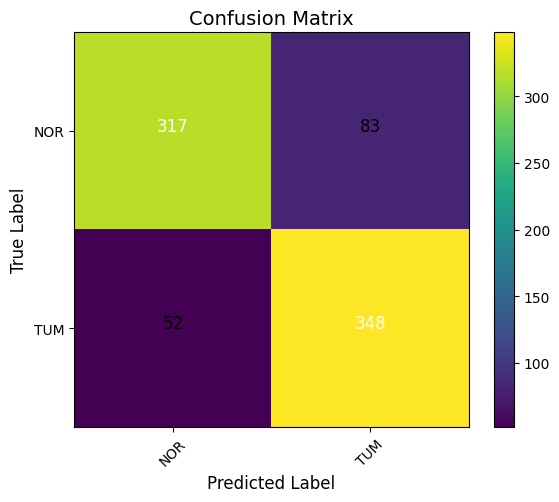

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
classes = target_names

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black",
                 fontsize=12)

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


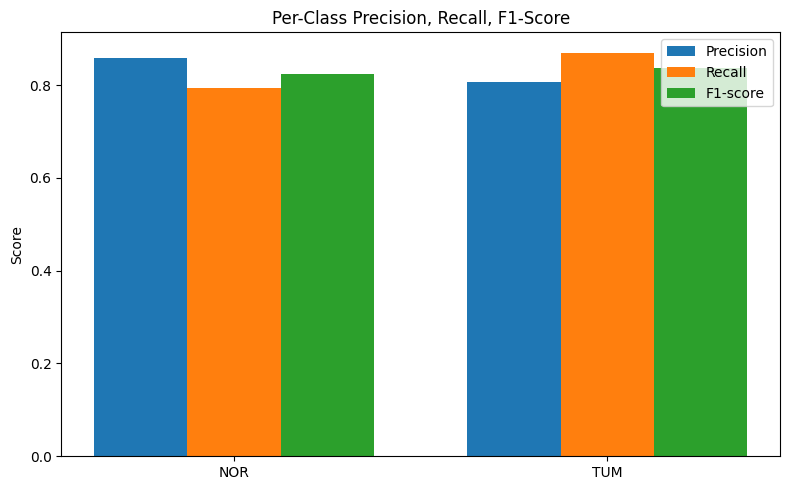

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

precisions = precision_score(all_labels, all_preds, average=None)
recalls = recall_score(all_labels, all_preds, average=None)
f1s = f1_score(all_labels, all_preds, average=None)

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1-score')

plt.xticks(x, classes)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1-Score")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = classifier(imgs)

        # predicted class index
        preds = outputs.argmax(1).cpu().numpy()

        # probability of class 1 (TUM)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        # store
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_probs.extend(probs.tolist())


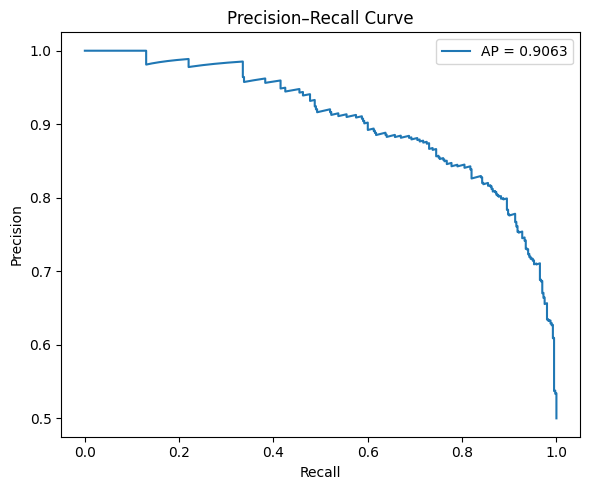

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, th = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


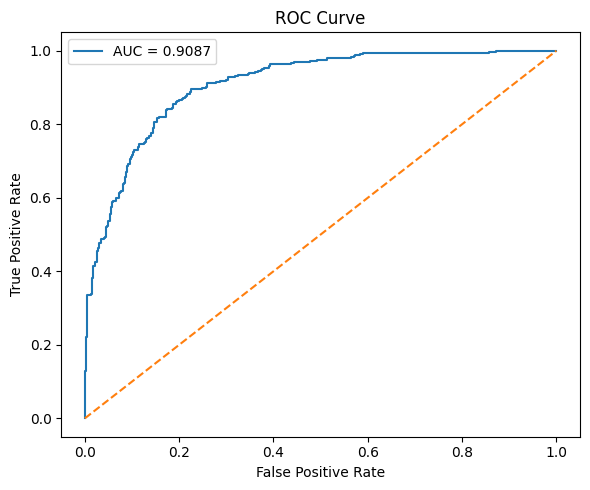

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Extract image paths and labels from your dataset
train_paths = [train_data.samples[i][0] for i in range(len(train_data))]
train_labels = [train_data.samples[i][1] for i in range(len(train_data))]

test_paths = [test_data.samples[i][0] for i in range(len(test_data))]
test_labels = [test_data.samples[i][1] for i in range(len(test_data))]


In [ ]:
# Combine TUM images from train + test based on label 1
all_tum_paths = [
    path for path, label in zip(train_paths + test_paths,
                                train_labels + test_labels)
    if label == 1
]


In [ ]:
all_tum_paths = sorted(all_tum_paths)

In [ ]:
from torchvision import transforms

infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
from PIL import Image

all_tum_embeddings = []

model.eval()
with torch.no_grad():
    for path in all_tum_paths:
        img = Image.open(path).convert("RGB")
        img = infer_transform(img)     # clean transform
        img = img.unsqueeze(0).to(device)

        emb = model(img)
        all_tum_embeddings.append(emb.cpu())

all_tum_embeddings = torch.cat(all_tum_embeddings, dim=0).numpy()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_tum_embeddings_scaled = scaler.fit_transform(all_tum_embeddings)


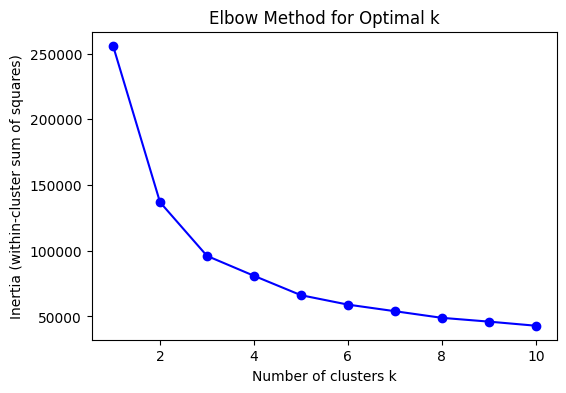

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia_list = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_tum_embeddings_scaled)
    inertia_list.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_values, inertia_list, 'o-', color='blue')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42,n_init=10)
tum_categories = kmeans.fit_predict(all_tum_embeddings_scaled)

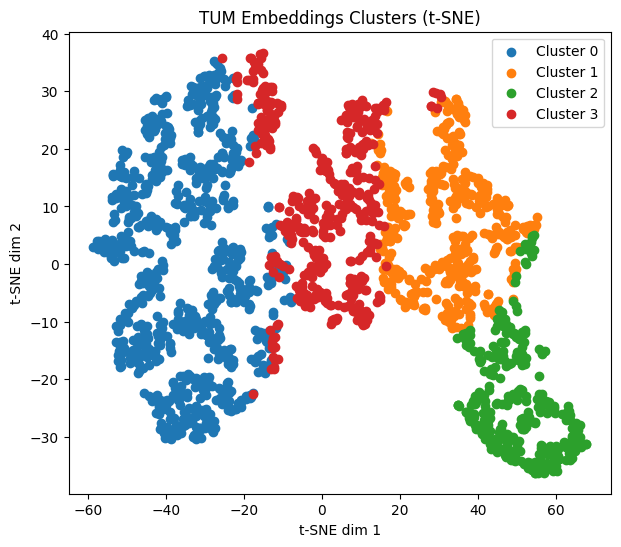

In [ ]:
# Import matplotlib for plotting and TSNE for dimensionality reduction
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce the dimensionality of the scaled TUM embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tum_embeddings_2d = tsne.fit_transform(all_tum_embeddings_scaled)

# Plot the clusters in the 2D t-SNE space
plt.figure(figsize=(7,6))
for cluster_id in range(4):
    cluster_points = tum_embeddings_2d[tum_categories == cluster_id]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f'Cluster {cluster_id}') # Label each cluster

plt.title("TUM Embeddings Clusters (t-SNE)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend()
plt.show()

In [ ]:
from collections import Counter

counts = Counter(tum_categories)
for cluster, count in counts.items():
    print(f"Cluster {cluster}: {count} samples")

Cluster 0: 827 samples
Cluster 2: 323 samples
Cluster 1: 424 samples
Cluster 3: 426 samples


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = all_tum_embeddings_scaled
y = np.array(tum_categories) # Convert cluster categories to a numpy array

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate Dice coefficient for each category (cluster)
num_classes = len(np.unique(y)) # Get the number of unique classes
dice_scores = []
for c in range(num_classes):
    pred_c = (y_pred == c).astype(int)
    label_c = (y_test == c).astype(int)
    intersection = np.sum(pred_c * label_c)
    dice = (2 * intersection) / (np.sum(pred_c) + np.sum(label_c) + 1e-8)
    dice_scores.append(dice)
print("Dice Coefficient per Category:", ["{:.4f}".format(d) for d in dice_scores])
print("Mean Dice Coefficient: {:.4f}".format(np.mean(dice_scores)))

Classification Report:
              precision    recall  f1-score   support

           0     0.9939    0.9879    0.9909       165
           1     0.9535    0.9647    0.9591        85
           2     0.9552    0.9846    0.9697        65
           3     0.9759    0.9529    0.9643        85

    accuracy                         0.9750       400
   macro avg     0.9696    0.9725    0.9710       400
weighted avg     0.9752    0.9750    0.9750       400

Confusion Matrix:
[[163   0   0   2]
 [  0  82   3   0]
 [  0   1  64   0]
 [  1   3   0  81]]
Dice Coefficient per Category: ['0.9909', '0.9591', '0.9697', '0.9643']
Mean Dice Coefficient: 0.9710


In [ ]:
import pandas as pd

df_clusters = pd.DataFrame({
    "image_path": all_tum_paths,
    "cluster_label": tum_categories
})

df_clusters.to_csv("tum_clusters.csv", index=False)
print("Saved as tum_clusters.csv")


Saved as tum_clusters.csv


In [ ]:
import pickle

d = {
    "scaler": scaler,
    "kmeans": kmeans,
    "rf_classifier": clf
}

# Save to a single pickle file
with open("clus_pipeline.pkl", "wb") as f:
    pickle.dump(d, f)